# Bangla Cyberbullying Binary Classification with XGBoost

This notebook implements a XGBoost classifier for binary classification of Bangla cyberbullying text (bullying vs. non-bullying).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.preprocessing import LabelEncoder
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets

In [3]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [4]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [5]:
# Map the labels for binary classification (0 for 'not bully', 1 for all other classes)
def binary_label_mapping(label):
    return 0 if label == "not bully" else 1

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].apply(binary_label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].apply(binary_label_mapping)

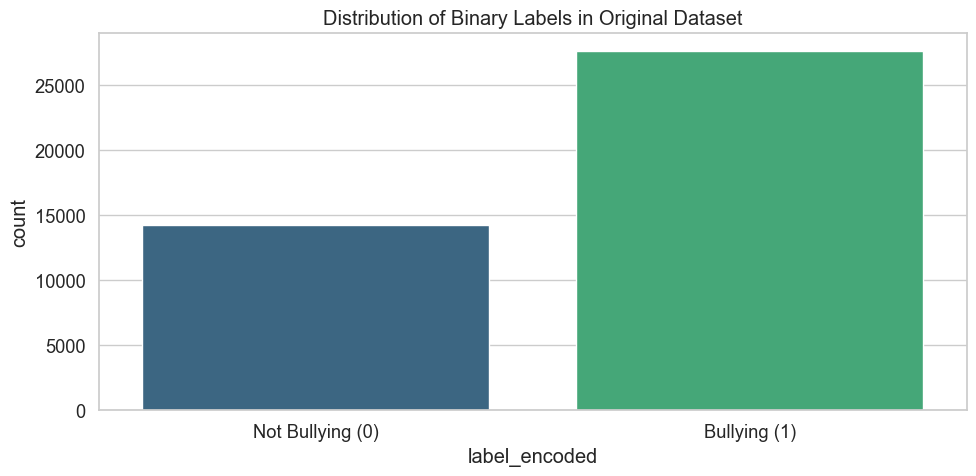

In [6]:
# Check the distribution of binary labels
plt.figure(figsize=(10, 5))
sns.countplot(x="label_encoded", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Binary Labels in Original Dataset")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [7]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [8]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


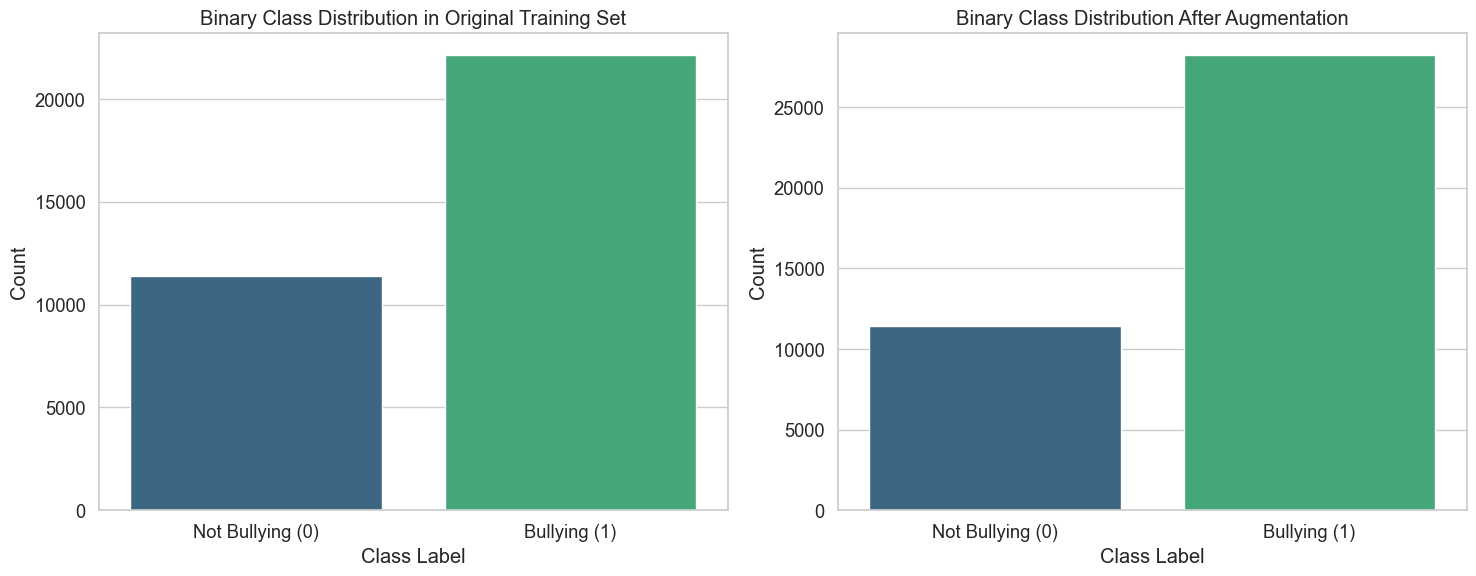

In [9]:
# Visualize the binary class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Binary Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Binary Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Vectorization

In [10]:
# Initialize SentencepieceTokenizer and BengaliFasttext
print("Initializing tokenizer and word embedding model...")
sp_tokenizer = SentencepieceTokenizer()
fasttext_model = BengaliFasttext()

Initializing tokenizer and word embedding model...


In [11]:
def tokenize_and_vectorize(text):
    # Tokenize the text
    tokens = sp_tokenizer.tokenize(text)

    # Get vector for each token and average them
    vectors = [
        fasttext_model.get_word_vector(token) for token in tokens if token.strip()
    ]

    # If no valid vectors, return zeros
    if not vectors:
        return np.zeros(300)  # FastText typically uses 300-dimensional vectors

    # Average the vectors
    return np.mean(vectors, axis=0)

In [12]:
# Apply tokenization and vectorization to training data
print("Vectorizing training data...")
start_time = time.time()
X_train_vectors = np.array([tokenize_and_vectorize(text) for text in X_train_augmented])
print(
    f"Training data vectorization completed in {time.time() - start_time:.2f} seconds"
)

Vectorizing training data...
Training data vectorization completed in 8.95 seconds


In [13]:
# Apply tokenization and vectorization to testing data
print("Vectorizing testing data...")
start_time = time.time()
X_test_vectors = np.array([tokenize_and_vectorize(text) for text in X_test])
print(f"Testing data vectorization completed in {time.time() - start_time:.2f} seconds")

Vectorizing testing data...
Testing data vectorization completed in 1.97 seconds


## 5. Training XGBoost Model

In [14]:
# Configure and train XGBoost classifier
print("Training XGBoost model...")
# Parameters optimized for text embeddings
xgb_model = XGBClassifier(
    n_estimators=200,         # Number of boosting rounds
    max_depth=6,              # Maximum tree depth
    learning_rate=0.1,        # Step size shrinkage used to prevent overfitting
    min_child_weight=1,       # Minimum sum of instance weight needed in a child
    gamma=0,                  # Minimum loss reduction required for further partition
    subsample=0.8,            # Fraction of samples used for fitting trees
    colsample_bytree=0.8,     # Fraction of features used for fitting trees
    scale_pos_weight=1,       # Control the balance of positive and negative weights
    objective='binary:logistic', # Binary classification objective
    random_state=42,
    n_jobs=-1                 # Use all processors
)

start_time = time.time()
xgb_model.fit(X_train_vectors, y_train_augmented)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training XGBoost model...
Model trained in 3.49 seconds


## 6. Model Evaluation - Basic Metrics

In [15]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
y_pred = xgb_model.predict(X_test_vectors)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Accuracy: 0.8169
Precision: 0.8161
Recall: 0.8169
F1 Score: 0.8091


In [16]:
# Display classification report for binary classification
print("Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Not Bullying", "Bullying"],
        digits=5,
    )
)

Classification Report:
              precision    recall  f1-score   support

Not Bullying    0.80988   0.60344   0.69158      2852
    Bullying    0.81924   0.92694   0.86977      5530

    accuracy                        0.81687      8382
   macro avg    0.81456   0.76519   0.78068      8382
weighted avg    0.81606   0.81687   0.80914      8382



## 7. Confusion Matrix Visualization

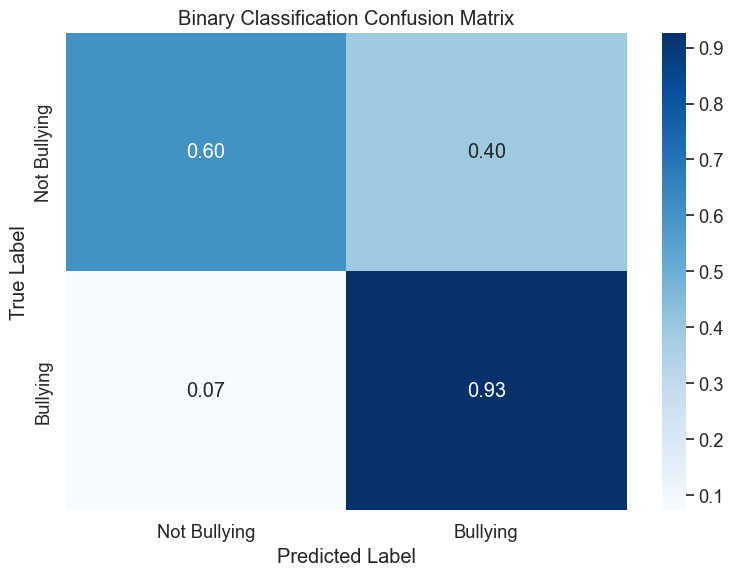

In [17]:
# Create and display confusion matrix for binary classification
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Not Bullying", "Bullying"],
    yticklabels=["Not Bullying", "Bullying"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classification Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

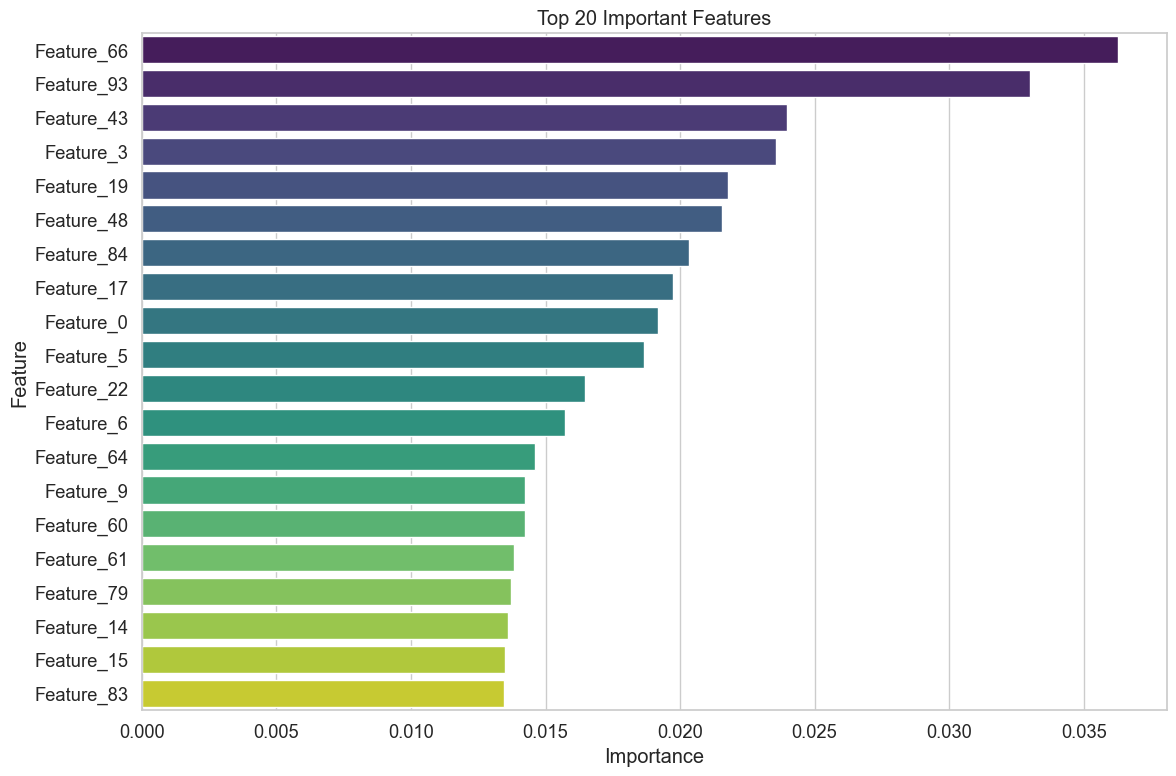

In [18]:
# Analyze feature importance
feature_importance = pd.DataFrame(
    {
        "Feature": [f"Feature_{i}" for i in range(X_train_vectors.shape[1])],
        "Importance": xgb_model.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("Importance", ascending=False).head(
    20
)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis

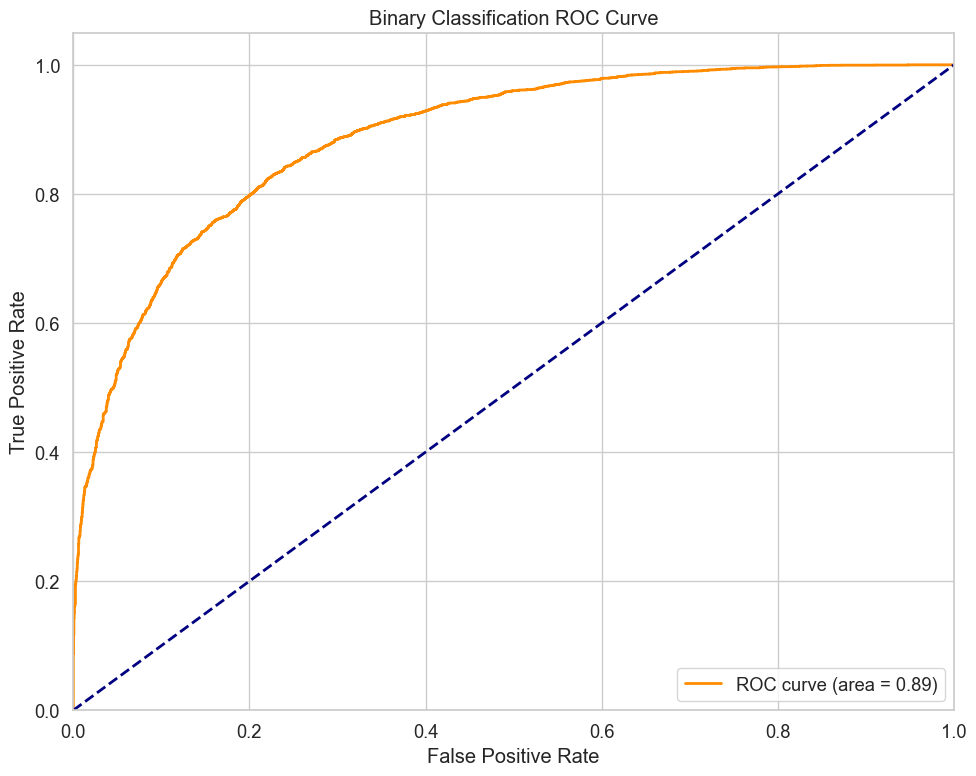

In [19]:
# ROC Curve and AUC for binary classification
y_score = xgb_model.predict_proba(X_test_vectors)[:, 1]  # Probability of positive class

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

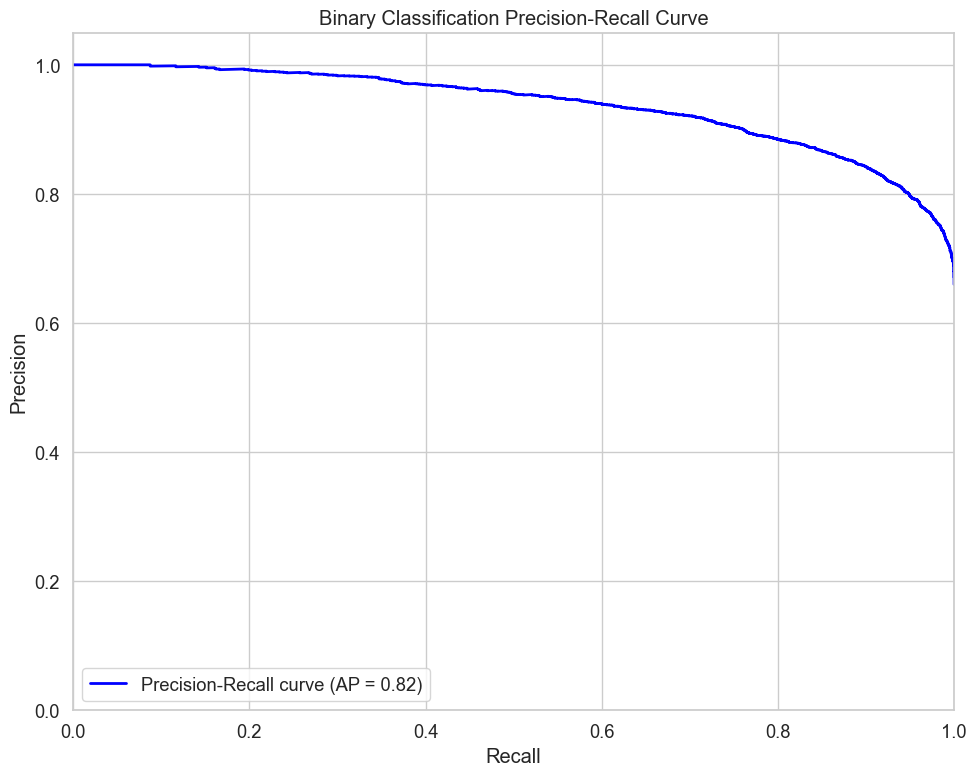

In [20]:
# Calculate Precision-Recall curve for binary classification
precision, recall, _ = precision_recall_curve(y_test, y_score)
avg_precision = precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Classification Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving

In [21]:
# Summary of the binary classification model
print("Binary Classification Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of features (vector dimension): {X_train_vectors.shape[1]}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

Binary Classification Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Number of features (vector dimension): 100
Final model accuracy on test set: 0.8169


In [22]:
# Save the model if needed
import joblib

joblib.dump(xgb_model, "../../models/xgboost/binary_xgboost.pkl")

['../../models/xgboost/binary_xgboost.pkl']